In [ ]:
# @title Initialising the session
#initializing
%%capture
!pip install transformers
!pip install torch torchaudio torchvision pandas
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
!pip install sentencepiece
!pip freeze | grep transformers
!pip install pandas
!pip install matplotlib
!pip install twilio

In [ ]:
# @title Main Model Pipeline
%%capture
#Model
import numpy as np
import locale
import whisper
import datetime
import subprocess
import torch
import torch.nn.functional as F
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
from pyannote.audio import Audio
from pyannote.core import Segment
import wave
import contextlib
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from transformers import pipeline
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import pandas as pd
import matplotlib as plt
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

def segment_embedding(segment,audio,duration,path):
  start = segment["start"]
  # Whisper overshoots the end timestamp in the last segment
  end = min(duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(path, clip)

  # Convert waveform to single channel
  waveform = waveform.mean(dim=0, keepdim=True)
  return embedding_model(waveform.unsqueeze(0))

def time(secs):
  return datetime.timedelta(seconds=round(secs))



class Analysis:

    def __init__(self):
        self.model_transcribe = whisper.load_model('medium')
        self.classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base",tokenizer='j-hartmann/emotion-english-distilroberta-base',)#top_k=None)
        self.translate_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
        self.translate_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")


    def transcribe(self, path,num_speakers):
        if path[-3:] != 'wav':
          subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
          path = 'audio.wav'
        result = self.model_transcribe.transcribe(path)
        segments = result["segments"]

        with contextlib.closing(wave.open(path,'r')) as f:
          frames = f.getnframes()
          rate = f.getframerate()
          duration = frames / float(rate)

        audio = Audio()

        embeddings = np.zeros(shape=(len(segments), 192))
        for i, segment in enumerate(segments):
          embeddings[i] = segment_embedding(segment,audio,duration,path)

        embeddings = np.nan_to_num(embeddings)

        clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
        labels = clustering.labels_
        for i in range(len(segments)):
          segments[i]["speaker"] = str(labels[i] + 1)

        f = open("transcript.txt", "w",encoding="UTF-8")

        for (i, segment) in enumerate(segments):
          if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
            f.write("\n")
          f.write(segment["text"][1:] + ' ')
        f.close()

        transcription_data=open('transcript.txt','r',encoding="UTF-8").read()
        print(transcription_data)
        return transcription_data


    def translate(self,text):
      self.translate_tokenizer.src_lang = "hi_IN"
      encoded_hi = self.translate_tokenizer(text, return_tensors="pt")
      generated_tokens = self.translate_model.generate(**encoded_hi, forced_bos_token_id=self.translate_tokenizer.lang_code_to_id["en_XX"])
      a = self.translate_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
      print(a)

      return a


    def classify(self, sentences):
      return self.classifier(sentences)


analysis=Analysis()

def process_input(path):
    a = analysis.transcribe(path,2)
    # Split input string by newline
    a = a.split('\n')

    # Initialize dictionary for storing analysis results
    j = {}

    # Iterate through the lines and perform translation
    for i in range(len(a)):
        if a[i] == '':
            pass
        else:
            j[i] = [int(i % 2), analysis.translate(a[i])]

    # Extract sentences
    sentences = []
    for value in j.values():
        sentences.extend(value[1])

    # Prepare a list of lists
    list_of_lists = [[sentence] for sentence in sentences]

    # Perform classification
    Output = []
    for i in range(len(list_of_lists)):
        Output.append(analysis.classify(list_of_lists[i]))

    # Prepare the final output
    final_output = {0: [], 1: []}
    for i in range(len(Output)):
        if i % 2 == 0:
            final_output[0].append(["".join(list_of_lists[i]), Output[i][0]['label']])
        else:
            final_output[1].append(["".join(list_of_lists[i]), Output[i][0]['label']])

    table_data = []
    for speaker, sentences in final_output.items():
        for sentence, emotion in sentences:
            table_data.append([speaker, sentence, emotion])

    df = pd.DataFrame(table_data, columns=["Speaker", "Sentence", "Emotion"])

    return df


In [ ]:
# @title VOIP Call

Number = "Select a number to call" # @param ["+919147064826", "+919816121909", "+918101419129", "Select a number to call"]
from twilio.rest import Client
from twilio.twiml.voice_response import VoiceResponse

account_sid='AC1ee586d8a786ae5655e408b671b05812'

auth_token='1dd04520a4319759fe69a568a26bf1cb'

client=Client(account_sid,auth_token)

call=client.calls.create(

                        twiml='<Response><Say>Hello, and welcome to our voice service.</Say></Response>',
                        url='https://demo.twilio.com/welcome/sms/reply',
                        to=Number,
                        from_="+16184946882",
                        record=True,
                        timeout=60
                                               )


print(call.sid)

CAccf084d65c762a2bcc63c52e44d180a6


In [ ]:
# @title Upload file
# upload audio file
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))


Saving 2023_09_23_10_06_13.m4a.mp3 to 2023_09_23_10_06_13.m4a.mp3


In [ ]:
# @title Run model
%%capture
df = process_input(path)



In [ ]:
# @title Display the data
#Print Output
df_speaker_0 = df[df['Speaker'] == 0]
df_speaker_1 = df[df['Speaker'] == 1]

# Reset the index for both DataFrames
df_speaker_0.reset_index(drop=True, inplace=True)
df_speaker_1.reset_index(drop=True, inplace=True)

# Initialize an empty list to store the merged rows
merged_rows = []

# Determine the length of the longer DataFrame
max_len = max(len(df_speaker_0), len(df_speaker_1))

# Merge the rows alternately
for i in range(max_len):
    if i < len(df_speaker_0):
        merged_rows.append(df_speaker_0.loc[i])
    if i < len(df_speaker_1):
        merged_rows.append(df_speaker_1.loc[i])

# Create a new DataFrame from the merged rows
merged_df = pd.DataFrame(merged_rows)

# Reset the index for the merged DataFrame
merged_df.reset_index(drop=True, inplace=True)
merged_df

,Speaker,Sentence,Emotion
0,0,Didn 't you go to class today?,surprise
1,1,"No, it was a bad day, so I couldn 't come. No,...",fear


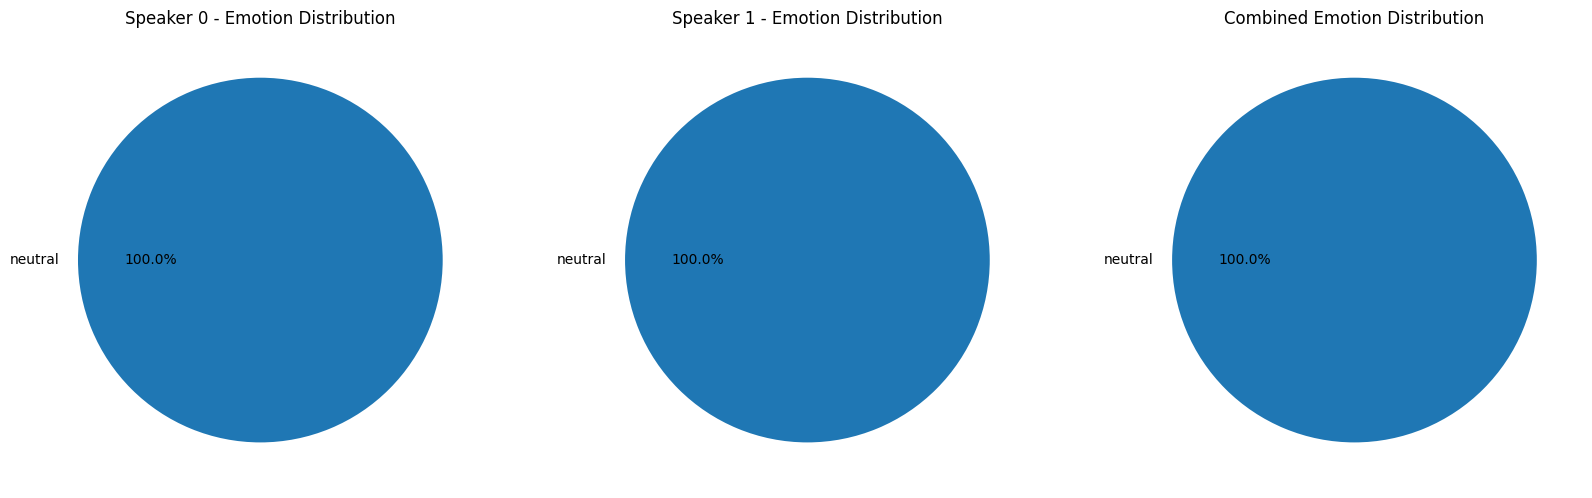

In [ ]:
# @title Visualizing the data
# Visualizing Output

import matplotlib.pyplot as plt

df_grouped = df.groupby(["Speaker", "Emotion"]).size().reset_index(name="Count")

# Create a figure and a grid of subplots with one row and three columns
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Plot the pie chart for each speaker
for i, speaker in enumerate(df_grouped["Speaker"].unique()):
    # Filter the dataframe by speaker
    df_speaker = df_grouped[df_grouped["Speaker"] == speaker]
    # Set the labels and sizes for the pie chart
    labels = df_speaker["Emotion"]
    sizes = df_speaker["Count"]
    # Set the title for the pie chart
    axs[i].set_title(f"Speaker {speaker} - Emotion Distribution")
    # Plot the pie chart on the i-th subplot
    axs[i].pie(sizes, labels=labels, autopct="%1.1f%%")

# Calculate combined emotion distribution
combined_df = df_grouped.groupby("Emotion")["Count"].sum().reset_index()

# Set the labels and sizes for the combined pie chart
labels_combined = combined_df["Emotion"]
sizes_combined = combined_df["Count"]

# Set the title for the combined pie chart
axs[2].set_title("Combined Emotion Distribution")

# Plot the combined pie chart on the third subplot
axs[2].pie(sizes_combined, labels=labels_combined, autopct="%1.1f%%")

# Show the figure
plt.show()




In [ ]:
# @title Run model
%%capture
df = process_input(path)



In [ ]:
# @title Display the data
#Print Output
df
df_speaker_0 = df[df['Speaker'] == 0]
df_speaker_1 = df[df['Speaker'] == 1]

# Reset the index for both DataFrames
df_speaker_0.reset_index(drop=True, inplace=True)
df_speaker_1.reset_index(drop=True, inplace=True)

# Initialize an empty list to store the merged rows
merged_rows = []

# Determine the length of the longer DataFrame
max_len = max(len(df_speaker_0), len(df_speaker_1))

# Merge the rows alternately
for i in range(max_len):
    if i < len(df_speaker_0):
        merged_rows.append(df_speaker_0.loc[i])
    if i < len(df_speaker_1):
        merged_rows.append(df_speaker_1.loc[i])

# Create a new DataFrame from the merged rows
merged_df = pd.DataFrame(merged_rows)

# Reset the index for the merged DataFrame
merged_df.reset_index(drop=True, inplace=True)
merged_df

In [ ]:
# @title Visualizing the data
#Visualizing Output
import matplotlib.pyplot as plt

df_grouped = df.groupby(["Speaker", "Emotion"]).size().reset_index(name="Count")

# Create a figure and a grid of subplots with one row and two columns
fig, axs = plt.subplots(1, 2,figsize=(16,8))

# Plot the pie chart for each speaker
for i, speaker in enumerate(df_grouped["Speaker"].unique()):
    # Filter the dataframe by speaker
    df_speaker = df_grouped[df_grouped["Speaker"] == speaker]
    # Set the labels and sizes for the pie chart
    labels = df_speaker["Emotion"]
    sizes = df_speaker["Count"]
    # Set the title for the pie chart
    axs[i].set_title(f"Speaker {speaker}")
    # Plot the pie chart on the i-th subplot
    axs[i].pie(sizes, labels=labels, autopct="%1.1f%%")

# Show the figure
plt.show()


In [ ]:
# @title end
import gradio as gr
import pandas as pd
import tempfile
import os

# Define the process_audio function that uses process_input
def process_audio(audio_file):
    # #this will return a dictionary containing sentences and emotions for dialog of each speaker
    results ,df= process_input(audio_file)

    # Create a table to display the results

    return df

audio_input = gr.inputs.Audio(label="Upload an audio file",source="upload",type="filepath")

output_text = gr.Dataframe(label="Result (Pandas DataFrame)",headers=['speaker', 'sentence', 'emotion']) # Remove the comma here

iface = gr.Interface(
    fn=process_audio,
    inputs=audio_input,
    outputs=output_text,
    title="Sentiment Analysis on call recordings",
    description="Upload an audio file to get the voice transcription with speaker diarization and the emotion of each dialog.",
    enable_queue=True
)

iface.launch(share=True,)
